In [1]:
import os
import sys
# Get the current working directory
current_directory = os.getcwd()
# Get the parent directory of the current working directory
parent_directory = os.path.dirname(current_directory)
# Append the parent directory to the Python path
sys.path.append(parent_directory)

import time
import gc
import pickle
import cv2
import torch
import numpy as np
from PIL import Image
from collections import OrderedDict

import torch
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from facenet_pytorch import InceptionResnetV1

from CustomAugment import RandomFlip, RandomRotation, RandomBrightnessContrast
from CustomAugment import Normalize, RandomGaussianNoise, RandomAugmentation
import mediapipe as mp

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Added imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# from ConvertVideoToFrame import FrameExtractor

# face_cropper = FrameExtractor(
#     video_path=parent_directory+'/dataset/videos', 
#     output_dir=parent_directory+'/dataset/videos_cropped', 
#     nframes=400)

# result = face_cropper.process_videos()
# print(result)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
face_detection = mp.solutions.face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.6)
weights_path = wp=parent_directory+'/models/facenet-vggface2.pt'
dataset_path = parent_directory+'/dataset/videos_cropped'
face_list = []  # list of cropped faces from photos folder
name_list = []  # list of names corrospoing to cropped photos
X_train, X_test, y_train, y_test = [], [], [], []
y_pred = [] 

start_time = time.time()

In [4]:
def elapsedTime(start_time):
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nElapsed time: {elapsed_time:.2f} seconds")

def collate_np(batch, class_to_idx):
    images, labels = zip(*batch)
    target_size = (160, 160)
    images_np = [cv2.resize(np.array(img), target_size) for img in images]
    labels_str = [list(class_to_idx.keys())[list(class_to_idx.values()).index(label)] for label in labels]
    return images_np, labels_str

def visualize_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        axes[i].imshow(images[i])
        # axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

In [5]:
print(f'Running on device: {device}')

resnet = InceptionResnetV1().to(device) # can only use cpu on my machine :<

state_dict = torch.load(weights_path)
filtered_state_dict = OrderedDict((k, v) for k, v in state_dict.items() if k not in ['logits.weight', 'logits.bias'])
resnet.load_state_dict(filtered_state_dict, strict=False)

resnet.eval()

path = dataset_path

# data_transforms = transforms.Compose([
#     RandomBrightnessContrast(brightness_range=(0.5, 1.5), contrast_range=(0.5, 1.5)),
#     RandomGaussianNoise(mean=0.0, std_range=(0.1, 0.3)),

#     transforms.ColorJitter(saturation=0.1, hue=0.1),
#     RandomRotation(angles=(-20, -1, 0, 1, 20)),
#     RandomFlip(p=0.5),

#     transforms.Resize((160, 160)),
#     Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

data_transforms = transforms.Compose([
    RandomAugmentation(),
    transforms.ColorJitter(saturation=0.15, hue=0.15),
    transforms.Resize((160, 160)),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if os.path.exists(path):
    dataset = datasets.ImageFolder(path, transform=data_transforms)

    idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}

    workers = 0 if os.name == 'nt' else 4
    loader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=True,
                        num_workers=workers,
                        collate_fn=lambda batch: collate_np(batch, dataset.class_to_idx)
                        )

    total_images = len(dataset)
    print(f"Total images: {total_images}")
else:
    print("Path doesn't exist")




Running on device: cpu
Total images: 2400


In [6]:
elapsedTime(start_time)

# display dataset after transform or during preprocessing
# Number of images to display
n_display = 24
display_count = 0
display_images = []
display_labels = []

for batch_idx, (inputs, labels) in enumerate(loader):
    # print(idx_to_class[idx[0]])
    print("Batch #: " + str(batch_idx))

    batch_size = len(inputs)  # Get the current batch size (may be smaller for the last batch)
    for j in range(batch_size):
        img = inputs[j]  # Get the j-th image in the batch
        label = labels[j]  # Get the j-th label in the batch

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        try:
            results = face_detection.process(img)
            # face, prob = mtcnn(img, return_prob=True)

            if results.detections:
                # Get the first detected face
                first_face = results.detections[0]

                bbox = first_face.location_data.relative_bounding_box
                x, y, w, h = int(bbox.xmin * img.shape[1]), int(bbox.ymin * img.shape[0]), \
                                int(bbox.width * img.shape[1]), int(bbox.height * img.shape[0])

                # Add padding to the image
                border = max(w, h)  # Use the maximum of width and height as the border size
                img_padded = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_CONSTANT,
                                                value=[0, 0, 0])

                # Crop the face region from the padded image
                face_image = img_padded[y + border:y + h + border, x + border:x + w + border]

                # Convert the cropped face from OpenCV's BGR format to RGB format
                face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
                # Convert the NumPy array to a PyTorch tensor
                face_image = torch.from_numpy(face_image).permute(2, 0, 1).float()

                face_list.append(face_image)
                name_list.append(label)  # names are stored in a list

                print(str(j), end='')
                if display_count < n_display:
                    display_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    display_labels.append(label)
                    display_count += 1
            else:
                print('.', end='')
                # print(idx_to_class[label])
                # print("No Face detected!")
                # pass
        except ValueError:
            print("Error detection!")
            continue

        # Perform garbage collection to free up memory
        del img
        gc.collect()

    elapsedTime(start_time)

# ...

print("Face detection complete...")
elapsedTime(start_time)


Elapsed time: 0.46 seconds
Batch #: 0
012345.789101112..15161718.202122232425262728293031
Elapsed time: 6.57 seconds
Batch #: 1
0123456.891011..141516.1819202122232425262728293031
Elapsed time: 12.78 seconds
Batch #: 2
.1.3.56789.11.....1718.202122.24..2728293031
Elapsed time: 18.78 seconds
Batch #: 3
0.23.56.8..111213.15161718192021222324....293031
Elapsed time: 24.76 seconds
Batch #: 4
.123.5678910111213141516171819.2122.24.26.28293031
Elapsed time: 30.43 seconds
Batch #: 5
.12.45.7891011.1314.1617.1920212223.25.2728...
Elapsed time: 35.92 seconds
Batch #: 6
0123.5.789.11.13.151617.1920.2223.25262728293031
Elapsed time: 41.70 seconds
Batch #: 7
0123.5678.101112131415161718192021....26272829.31
Elapsed time: 47.57 seconds
Batch #: 8
0.2345678910111213.1516171819.2122232425262728293031
Elapsed time: 53.25 seconds
Batch #: 9
0123456.89.1112.14.1617.19.21.232425262728293031
Elapsed time: 58.85 seconds
Batch #: 10
.123.56789.111213141516.1819202122232425.272829.31
Elapsed time: 64.39 sec

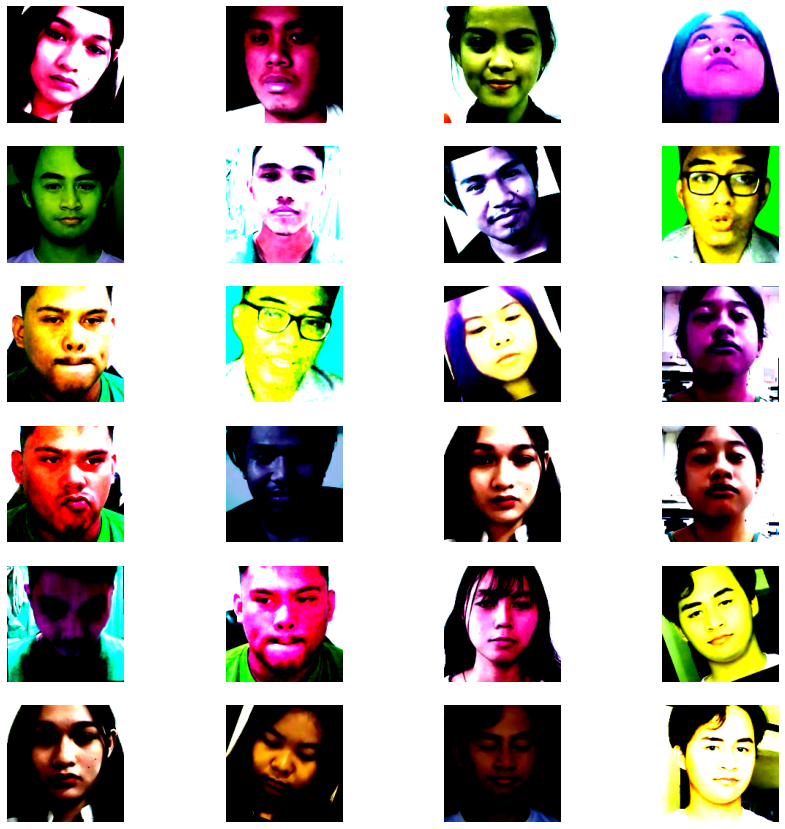

In [7]:
visualize_images(display_images, display_labels, 6, 4)
del display_images
del display_labels

In [8]:
from sklearn.utils import shuffle

face_list_resized = []
for face in face_list:
    face_np = face.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy array and change channel order
    face_pil = Image.fromarray(face_np.astype('uint8'))  # Convert NumPy array to PIL image
    face_pil_resized = face_pil.resize((160, 160), Image.ANTIALIAS)  # Resize the PIL image
    face_resized = transforms.ToTensor()(face_pil_resized)  # Convert the resized PIL image back to a tensor
    face_list_resized.append(face_resized)



In [9]:
# print(face_list)
if len(face_list_resized) > 0:
    aligned = torch.stack(face_list_resized)
    
    del face_list_resized

    names = np.array(name_list)

    # Disable gradient calculation during inference
    with torch.no_grad():
        # Calculate the embeddings for the aligned faces
        embeddings = resnet(aligned).detach().cpu()

        # Encode the labels
        le = LabelEncoder()
        y = le.fit_transform(names)

else:
    print("No faces were found in the dataset. Please check the input images.")


In [10]:
# Define hyperparameters
C = 1.0  # SVM regularization parameter
gamma = 'scale'  # RBF kernel width parameter
print("Training SVM with RBF kernel...")
elapsedTime(start_time)
# Train an SVM with RBF kernel using Mini-batch Gradient Descent
# Initialize the SVM classifier
clf = SVC(C=C, kernel='rbf', gamma=gamma)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)


# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Train the classifier on the mini-batch
clf.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
elapsedTime(start_time)


# Save the trained model and the name list as a pickle file
with open("svm-rbf_classifier.pkl", "wb") as f:
    pickle.dump((clf, le, name_list, X_train, X_test, y_train, y_test), f)

# # Load the trained model and the name list from the pickle file
# with open("svm-rbf_classifier.pkl", "rb") as f:
#     loaded_clf, loaded_le, loaded_name_list = pickle.load(f)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")
elapsedTime(start_time)

Training SVM with RBF kernel...

Elapsed time: 479.70 seconds
Accuracy: 0.95

Elapsed time: 479.98 seconds
Accuracy on the test set: 0.95

Elapsed time: 480.06 seconds


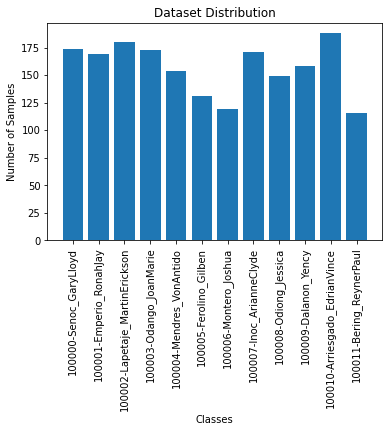

In [11]:
# Visualize dataset distribution
unique, counts = np.unique(name_list, return_counts=True)
plt.figure()
plt.bar(unique, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Dataset Distribution')
plt.xticks(rotation=90)
plt.show()

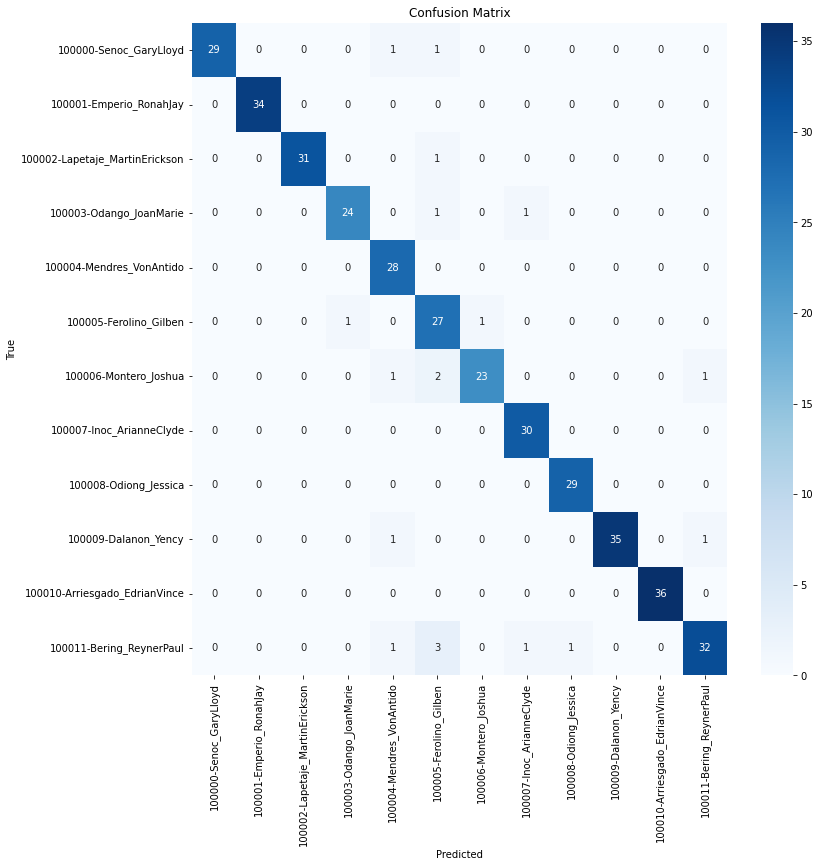

In [12]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Visualize classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

                                precision    recall  f1-score   support

        100000-Senoc_GaryLloyd       1.00      0.94      0.97        31
       100001-Emperio_RonahJay       1.00      1.00      1.00        34
100002-Lapetaje_MartinErickson       1.00      0.97      0.98        32
       100003-Odango_JoanMarie       0.96      0.92      0.94        26
      100004-Mendres_VonAntido       0.88      1.00      0.93        28
        100005-Ferolino_Gilben       0.77      0.93      0.84        29
         100006-Montero_Joshua       0.96      0.85      0.90        27
      100007-Inoc_ArianneClyde       0.94      1.00      0.97        30
         100008-Odiong_Jessica       0.97      1.00      0.98        29
          100009-Dalanon_Yency       1.00      0.95      0.97        37
 100010-Arriesgado_EdrianVince       1.00      1.00      1.00        36
      100011-Bering_ReynerPaul       0.94      0.84      0.89        38

                      accuracy                           0.95 